## **Network Inversion for Uncertainty-Aware Out-of-Distribution Detection**


#### Importing required Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### Loading datasets

In [5]:
# MNIST Dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# FashionMNIST Dataset
fmnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fmnist_test  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.28MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.53MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 15.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.6MB/s]


In [6]:
print(f"""mnist_train:{len(mnist_train)}
mnist_test :{len(mnist_test)}

fmnist_train:{len(fmnist_train)}
fmnist_test :{len(fmnist_test)} """)

mnist_train:60000
mnist_test :10000

fmnist_train:60000
fmnist_test :10000 


In [7]:
# Transformation: RGB → Grayscale → Resize → Tensor + Normalize
ood_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))          # Match MNIST normalization
])

In [8]:
# FashionMNIST Dataset
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ood_transform)
cifar10_test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)

100%|██████████| 170M/170M [00:01<00:00, 92.1MB/s]


In [9]:
print(f"""cifar10_train:{len(cifar10_train)}
cifar10_test :{len(cifar10_test)}""")

cifar10_train:50000
cifar10_test :10000


In [10]:
# FashionMNIST Dataset
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=ood_transform)
svhn_test  = torchvision.datasets.SVHN(root='./data', split= 'test', download=True, transform=ood_transform)

100%|██████████| 182M/182M [00:08<00:00, 20.9MB/s]
100%|██████████| 64.3M/64.3M [00:05<00:00, 11.2MB/s]


In [11]:
print(f"""svhn_train:{len(svhn_train)}
svhn_test :{len(svhn_test)}""")

svhn_train:73257
svhn_test :26032


In [12]:
from torch.utils.data import ConcatDataset
full_fmnist  = ConcatDataset([fmnist_train, fmnist_test])
full_cifar10 = ConcatDataset([cifar10_train, cifar10_test])
full_svhn    = ConcatDataset([svhn_train, svhn_test])

In [13]:
from torch.utils.data import TensorDataset

mnist_train_images = torch.stack([img for img, _ in mnist_train])
mnist_train_labels = torch.tensor([label for _, label in mnist_train], dtype=torch.long)
mnist_train_dataset = TensorDataset(mnist_train_images, mnist_train_labels)

In [14]:
from torch.utils.data import TensorDataset

mnist_test_images = torch.stack([img for img, _ in mnist_test])
mnist_test_labels = torch.tensor([label for _, label in mnist_test], dtype=torch.long)
mnist_test_dataset = TensorDataset(mnist_test_images, mnist_test_labels)

In [15]:
def map_labels_to_garbage(dataset, garbage_label=10):

    images, labels = [], []
    for img, _ in dataset:
        images.append(img)
        labels.append(garbage_label)
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(images, labels)

In [16]:
ood_fmnist  = map_labels_to_garbage(full_fmnist, garbage_label=10)
ood_cifar10 = map_labels_to_garbage(full_cifar10, garbage_label=10)
ood_svhn    = map_labels_to_garbage(full_svhn, garbage_label=10)

### Generating Gaussian Noise Samples for Garbage Class

In [17]:
# Extract labels from the mnist training dataset
mnist_labels = torch.tensor([label for _, label in mnist_train_dataset], dtype=torch.long)

# Count occurrences of each class
class_counts = torch.bincount(mnist_labels)

# Print counts
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} images")

Class 0: 5923 images
Class 1: 6742 images
Class 2: 5958 images
Class 3: 6131 images
Class 4: 5842 images
Class 5: 5421 images
Class 6: 5918 images
Class 7: 6265 images
Class 8: 5851 images
Class 9: 5949 images


In [18]:
# Parameters for noise generation
num_noise_samples = 6000
channels, height, width = 1, 28, 28

# Generate Gaussian noise samples (standard normal distribution)
noise_samples  = torch.randn(num_noise_samples, channels, height, width)

# Create labels for these noise samples (all set to 10, the garbage class)
garbage_labels = torch.full((num_noise_samples,), 10, dtype=torch.long)

# Create a dataset for the noise samples
noise_dataset_train  = TensorDataset(noise_samples, garbage_labels)

# Combine the mnist train dataset with the noise dataset
combined_mnist_train = ConcatDataset([mnist_train_dataset, noise_dataset_train])

In [19]:
# Extract labels from the dataset
mnist_labels = torch.tensor([label for _, label in mnist_test_dataset], dtype=torch.long)

# Count occurrences of each class
class_counts = torch.bincount(mnist_labels)

# Print counts
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} images")

Class 0: 980 images
Class 1: 1135 images
Class 2: 1032 images
Class 3: 1010 images
Class 4: 982 images
Class 5: 892 images
Class 6: 958 images
Class 7: 1028 images
Class 8: 974 images
Class 9: 1009 images


In [20]:
# Parameters for noise generation
num_noise_samples = 1000
channels, height, width = 1, 28, 28

# Generate Gaussian noise samples (standard normal distribution)
noise_samples  = torch.randn(num_noise_samples, channels, height, width)

# Create labels for these noise samples (all set to 10, the garbage class)
garbage_labels = torch.full((num_noise_samples,), 10, dtype=torch.long)

# Create a dataset for the noise samples
noise_dataset_test  = TensorDataset(noise_samples, garbage_labels)

# Combine the mnist test dataset with the noise dataset
combined_mnist_test = ConcatDataset([mnist_test_dataset, noise_dataset_test])

In [21]:
# print dataset sizes for verification
print("Full MNIST size:", len(mnist_train_dataset))
print("Noise dataset size:", len(noise_dataset_train))
print("Combined MNIST size:", len(combined_mnist_train))

Full MNIST size: 60000
Noise dataset size: 6000
Combined MNIST size: 66000


In [22]:
# print dataset sizes for verification
print("Full MNIST size:", len(mnist_test_dataset))
print("Noise dataset size:", len(noise_dataset_test))
print("Combined MNIST size:", len(combined_mnist_test))

Full MNIST size: 10000
Noise dataset size: 1000
Combined MNIST size: 11000


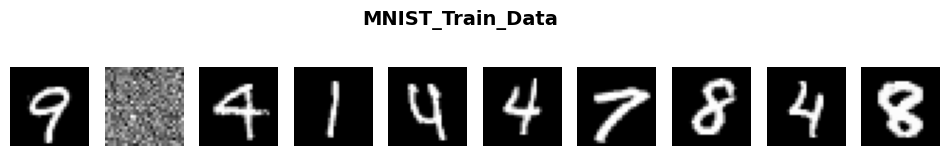

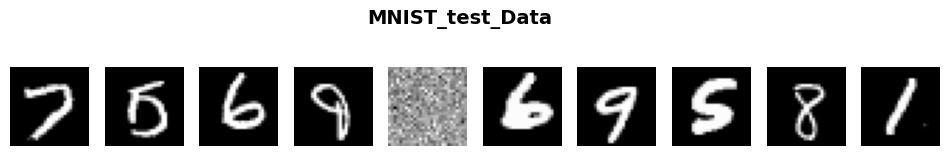

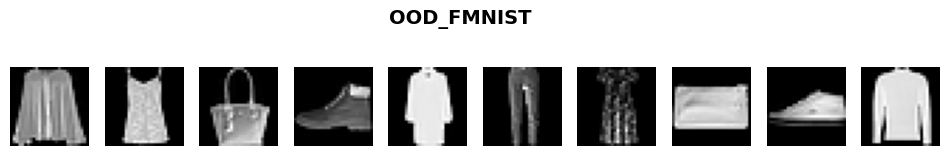

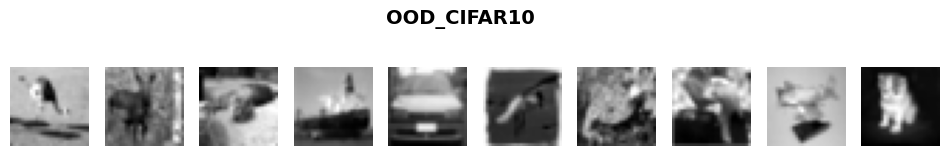

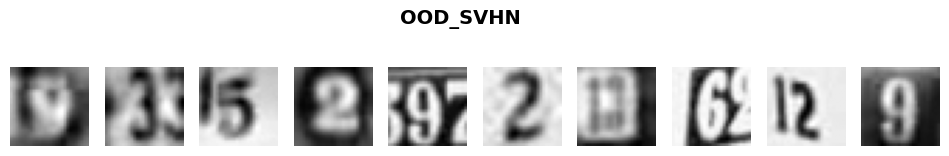

In [22]:
import random

# Number of samples per dataset
num_samples = 10

# Randomly sample indices from the combined dataset
sample_indices_1 = random.sample(range(len(combined_mnist_train)), num_samples)
sample_indices_2 = random.sample(range(len(combined_mnist_test)), num_samples)
sample_indices_3 = random.sample(range(len(ood_fmnist)), num_samples)
sample_indices_4 = random.sample(range(len(ood_cifar10)), num_samples)
sample_indices_5 = random.sample(range(len(ood_svhn)), num_samples)

mnist_train_images, _ = zip(*[combined_mnist_train[i] for i in sample_indices_1])
mnist_test_images, _  = zip(*[combined_mnist_test[i] for i in sample_indices_2])
fmnist_images, _      = zip(*[ood_fmnist[i] for i in sample_indices_3])
cifar10_images, _     = zip(*[ood_cifar10[i] for i in sample_indices_4])
svhn_images, _        = zip(*[ood_svhn[i] for i in sample_indices_5])


# Convert tensors to NumPy arrays
mnist_train_images = [img.numpy() for img in mnist_train_images]
mnist_test_images  = [img.numpy() for img in mnist_test_images]
fmnist_images      = [img.numpy() for img in fmnist_images]
cifar10_images     = [img.numpy() for img in cifar10_images]
svhn_images        = [img.numpy() for img in svhn_images]

# Function to plot images for a given dataset
def plot_images(images, title):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        axes[i].imshow(images[i][0], cmap="gray")  # Grayscale image
        axes[i].axis("off")
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.show()

# Plot each dataset separately
plot_images(mnist_train_images, "MNIST_Train_Data")
plot_images(mnist_test_images, "MNIST_test_Data")
plot_images(fmnist_images, "OOD_FMNIST")
plot_images(cifar10_images, "OOD_CIFAR10")
plot_images(svhn_images, "OOD_SVHN")

## DataLoaders


In [23]:
# Create a DataLoader for the datasets
from torch.utils.data import DataLoader

batch_size          = 64
mnist_train_loader  = DataLoader(combined_mnist_train, batch_size=batch_size, shuffle=True )
mnist_test_loader   = DataLoader(combined_mnist_test , batch_size=batch_size, shuffle=False)
fmnist_loader       = DataLoader(ood_fmnist          , batch_size=batch_size, shuffle=False)
cifar10_loader      = DataLoader(ood_cifar10         , batch_size=batch_size, shuffle=False)
svhn_loader         = DataLoader(ood_svhn            , batch_size=batch_size, shuffle=False)

# Classifier

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ExtendedCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(ExtendedCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1     = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2     = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers + pooling
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Penultimate layer: fc1 and dropout
        features = F.leaky_relu(self.fc1(x))
        features_after_dropout = self.dropout(features)

        # Final logits
        logits = self.fc2(features_after_dropout)

        return logits, features

In [25]:
# Set up device, instantiate model, loss, and optimizer
import torch.optim as optim

model = ExtendedCNN(num_classes=11).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [27]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Directory in Google Drive to store checkpoints
checkpoint_dir = "/content/drive/MyDrive/OOD_RnD/pretrained_dir"
os.makedirs(checkpoint_dir, exist_ok=True)

In [29]:
import os
import torch

def train_classifier(train_loader, checkpoint_dir, criterion, device, num_classes=11, num_epochs=1):

    model = ExtendedCNN(num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    train_accuracies = []

    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, _ = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, checkpoint_path)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return model, train_losses, train_accuracies

In [30]:
model, train_losses, train_acc = train_classifier(mnist_train_loader, checkpoint_dir, criterion, device, num_classes=11,num_epochs=1)

Epoch [1/1] - Loss: 0.1771, Accuracy: 94.65%


In [30]:
# Function to find the latest checkpoint
def find_latest_checkpoint(checkpoint_dir):

    # List all files in the checkpoint directory
    checkpoint_files = os.listdir(checkpoint_dir)

    # Filter files that match the checkpoint pattern
    checkpoint_files = [f for f in checkpoint_files if f.startswith("checkpoint_epoch_") and f.endswith(".pt")]

    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found in the directory.")

    # Extract epoch numbers from filenames
    epoch_numbers = [int(re.search(r"checkpoint_epoch_(\d+).pt", f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint = f"checkpoint_epoch_{latest_epoch}.pt"
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    return latest_checkpoint_path

In [31]:
def load_model_from_checkpoint(checkpoint_path, model_class, num_classes, device):
    model      = model_class(num_classes=num_classes).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [32]:
import re

# Find and load the latest checkpoint
latest_checkpoint_path = find_latest_checkpoint(checkpoint_dir)
print(f"Loading latest checkpoint: {latest_checkpoint_path}")

# Load the model
model = load_model_from_checkpoint(latest_checkpoint_path, ExtendedCNN, num_classes=11, device=device)
model.eval()

# Get a batch of images
images, labels = next(iter(mnist_train_loader))
images = images.to(device)

# Forward pass to get features
with torch.no_grad():
    logits, features = model(images)

# Move features to CPU and convert to numpy
features_np = features.cpu().numpy()
labels_np   = labels.cpu().numpy()

Loading latest checkpoint: /content/drive/MyDrive/OOD_RnD/pretrained_dir/checkpoint_epoch_1.pt


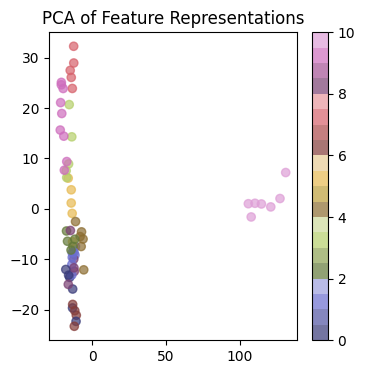

In [38]:
# PCA to visualize these features
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_np)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_np, cmap='tab20b', alpha=0.7)
plt.colorbar(scatter)
plt.title("PCA of Feature Representations")
plt.show()

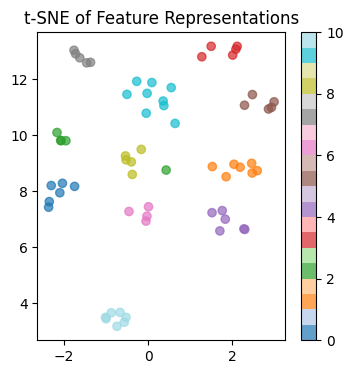

In [39]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce features to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
features_2d_tsne = tsne.fit_transform(features_np)

plt.figure(figsize=(4,4))
scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=labels_np, cmap='tab20', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of Feature Representations")
plt.show()

In [33]:
from collections import defaultdict

def test_classifier(test_loader, model, criterion, device, num_classes=11):

    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Track per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():  # No gradient computation during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits, features = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            # Predictions
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Track class-wise performance
            for label, pred in zip(labels, predicted):
                class_total[label.item()] += 1
                class_correct[label.item()] += (label == pred).item()

    # Compute average loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total

    # Print overall accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # # Print per-class accuracy
    # print("\nPer-Class Accuracy:")
    # for cls in range(num_classes):
    #     if class_total[cls] == 0:
    #         print(f"  Class {cls}: No samples in test set")
    #     else:
    #         acc = 100.0 * class_correct[cls] / class_total[cls]
    #         print(f"  Class {cls}: {acc:.2f}% ({class_correct[cls]}/{class_total[cls]})")

    return test_loss, test_acc

In [41]:
test_loss, test_acc = test_classifier(mnist_test_loader, model, criterion, device)

Test Loss: 0.0415, Test Accuracy: 98.66%


In [42]:
test_loss, test_acc = test_classifier(fmnist_loader, model, criterion, device)

Test Loss: 2.8237, Test Accuracy: 30.97%


In [43]:
test_loss, test_acc = test_classifier(cifar10_loader, model, criterion, device)

Test Loss: 0.0475, Test Accuracy: 98.80%


In [44]:
test_loss, test_acc = test_classifier(svhn_loader, model, criterion, device)

Test Loss: 0.0285, Test Accuracy: 99.73%


# Generator

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InversionGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, image_size=28, img_channels=1):
        super(InversionGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_channels = img_channels
        self.init_size = image_size // 4  # 28 -> 7

        # Project and reshape latent + condition to a feature map
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.BatchNorm1d(128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        # Convolutional Upsampling Blocks using ConvTranspose2d
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, img_channels, kernel_size=3, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z, cond):
        x = torch.cat([z, cond], dim=1)  # [B, latent_dim + num_classes]
        x = self.fc(x)                   # [B, 128 * 7 * 7]
        x = x.view(-1, 128, self.init_size, self.init_size)  # [B, 128, 7, 7]
        img = self.conv_blocks(x)       # [B, 1, 28, 28]
        return img

In [46]:
latent_dim  = 100
num_classes = 11
generator   = InversionGenerator(latent_dim, num_classes, image_size=28, img_channels=1)

In [47]:
# Generate a random latent vector and a random conditioning vector
batch_size = 500
z = torch.randn(batch_size, latent_dim)

# For conditioning: generate random values then apply softmax to simulate a distribution
cond_raw = torch.randn(batch_size, num_classes)
cond_dist = F.softmax(cond_raw, dim=1)

# Generate images
gen_images = generator(z, cond_dist)
print("Generated images shape:", gen_images.shape)  # Should be [500, 1, 28, 28]

Generated images shape: torch.Size([500, 1, 28, 28])


In [48]:
def generate_images(no_of_samples):

  z = torch.randn(no_of_samples, latent_dim)

  # For conditioning: generate random values then apply softmax to simulate a distribution
  cond_raw = torch.randn(no_of_samples, num_classes)
  cond_dist = F.softmax(cond_raw, dim=1)

  # Generate images
  gen_images = generator(z, cond_dist)

  return gen_images

In [49]:
def update_dataset(gen_images, current_dataset, batch_size):

    # Check if there are any generated images
    if gen_images is None or gen_images.size(0) == 0:
        print("Warning: No generated images provided for dataset update.")
        return current_dataset, DataLoader(current_dataset, batch_size=batch_size, shuffle=True)

    # Move generated images and labels to CPU
    gen_images = gen_images.cpu()  # Move images to CPU
    num_gen_samples = gen_images.size(0)
    gen_labels = torch.full((num_gen_samples,), 10, dtype=torch.long)  # Labels are already on CPU

    # Create a dataset for the generated samples
    gen_dataset = TensorDataset(gen_images, gen_labels)

    # Combine the existing dataset with the new generated dataset
    updated_dataset = ConcatDataset([current_dataset, gen_dataset])

    # Recreate the DataLoader for the updated dataset
    train_loader = DataLoader(updated_dataset, batch_size=batch_size, shuffle=True)

    return updated_dataset, train_loader

# Losses

In [50]:
from collections import Counter
import torch

def compute_dynamic_weights(current_dataset,num_classes=11):

  # Count occurrences of each label in the current dataset
  all_labels = [label.item() for _, label in current_dataset]
  total_counts = Counter(all_labels)

  # Initialize updated counts
  updated_counts = {i: total_counts.get(i, 1e-6) for i in range(num_classes)}  # All classes (0-10)

  # Compute weights
  total_samples = sum(updated_counts.values())
  weights = [total_samples / (num_classes * updated_counts[i]) for i in range(num_classes)]  # Avoid division by zero

  # Convert to PyTorch tensor
  weights = torch.tensor(weights, dtype=torch.float, device=device)

  return weights

In [51]:
def kl_divergence(logits, cond_dist):

    q_dist = F.softmax(logits, dim=1)  # [B, 11]
    kl_loss = torch.sum(cond_dist * torch.log((cond_dist + 1e-8) / (q_dist + 1e-8)), dim=1).mean()
    return kl_loss

In [52]:
def cross_entropy(logits, target_labels):

  ce_loss = F.cross_entropy(logits, target_labels)

  return ce_loss

In [53]:
def cosine_similarity(features):

  # Normalize features so that cosine similarity equals the dot product.
  normalized_features = F.normalize(features, p=2, dim=1)  # [B, D]
  # Compute cosine similarity matrix: [B, B]
  cos_sim_matrix = torch.matmul(normalized_features, normalized_features.t())
  B = features.size(0)
  # Exclude diagonal elements (self-similarity)
  mask = torch.ones_like(cos_sim_matrix) - torch.eye(B, device=cos_sim_matrix.device)
  cos_sim_sum = torch.sum(cos_sim_matrix * mask)
  num_pairs = B * (B - 1)
  cos_loss = cos_sim_sum / (num_pairs + 1e-8)

  return cos_loss

In [54]:
def feature_orthogonality(features):

  B = features.size(0)
  G = torch.matmul(features, features.t())  # [B, B]
  I = torch.eye(B, device=features.device)
  ortho_loss = F.mse_loss(G, I)
  return ortho_loss

In [55]:
def compute_inversion_loss(gen_imgs, target_labels, cond_dist, model, alpha, beta, gamma, delta):

    logits, features = model(gen_imgs)
    ce_loss = cross_entropy(logits, target_labels)
    kl_loss = kl_divergence(logits, cond_dist)
    cos_loss = cosine_similarity(features)
    ortho_loss = feature_orthogonality(features)

    total_loss = alpha * kl_loss + beta * ce_loss + gamma * cos_loss + delta * ortho_loss
    return total_loss, (ce_loss, kl_loss, cos_loss, ortho_loss)

In [56]:
def uncertainty_estimate(logits, no_of_classes=11):

    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    n = no_of_classes - 1

    # Uniform distribution
    uniform = torch.full_like(probs, 1.0 / (n + 1))

    # a: Squared error between prediction and uniform
    a = torch.sum((probs - uniform) ** 2, dim=1)

    # b: Squared error between one-hot of argmax and uniform
    preds = torch.argmax(probs, dim=1)
    one_hot = F.one_hot(preds, num_classes=no_of_classes).float()
    b = torch.sum((one_hot - uniform) ** 2, dim=1)

    # Uncertainty Estimate
    ue = 1 - (a / b)
    return ue  # Shape: [batch_size]

In [57]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import Counter, defaultdict
from tqdm import tqdm
import os
import torchvision.utils as vutils
from pathlib import Path
import shutil
from collections import Counter

# === Hyperparameters ===

# Hyperparameters for the inversion loss components
alpha = 500   # Weight for KL divergence loss
beta  = 500   # Weight for cross-entropy loss
gamma = 6000   # Weight for cosine similarity loss
delta = 10   # Weight for feature orthogonality loss


latent_dim = 100
num_classes = 11
batch_size = 64
num_of_samples = 1000
steps_per_epoch = 250
num_epochs = 50

# === Directories ===

pretrained_dir = "/content/drive/MyDrive/OOD_RnD/pretrained_dir"
iterative_ckpt_dir = "/content/drive/MyDrive/OOD_RnD/iterative_ckpt_dir"
gen_data_dir = "/content/drive/MyDrive/OOD_RnD/gen_data_dir"


# === Reset generated_samples directory if needed ===
if os.path.exists(gen_data_dir):
    shutil.rmtree(gen_data_dir)
os.makedirs(gen_data_dir, exist_ok=True)

if os.path.exists(iterative_ckpt_dir):
    shutil.rmtree(iterative_ckpt_dir)
os.makedirs(iterative_ckpt_dir, exist_ok=True)



# === Load Pretrained Classifier ===
if not os.path.exists(os.path.join(iterative_ckpt_dir, "checkpoint_epoch_0.pt")):
    pretrained_ckpt_path = find_latest_checkpoint(pretrained_dir)
    initial_model = load_model_from_checkpoint(pretrained_ckpt_path, ExtendedCNN, num_classes=11, device=device)
    torch.save({'model_state_dict': initial_model.state_dict()},
               os.path.join(iterative_ckpt_dir, "checkpoint_epoch_0.pt"))
    print("Saved pretrained model to checkpoint_epoch_0.pt")

# === Main Loop ===
current_dataset = combined_mnist_train  # e.g., MNIST + Gaussian dataset
train_loader = DataLoader(current_dataset, batch_size=batch_size, shuffle=True)

generator = InversionGenerator(latent_dim, num_classes, image_size=28, img_channels=1)
generator.to(device)
optimizer_gen = optim.Adam(generator.parameters(), lr=0.001)
generator.train()

inversion_accuracy_history = []
uncertainty_per_epoch = {}
train_loss_history = []
train_acc_history = []

criterion = torch.nn.CrossEntropyLoss()





for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch} ---")

    # # === Reset generator each epoch ===
    # generator = Generator(latent_dim=latent_dim, num_classes=num_classes)
    # generator.to(device)
    # optimizer_gen = optim.Adam(generator.parameters(), lr=0.001)

    # === Load and Freeze Classifier ===
    ckpt_path = os.path.join(iterative_ckpt_dir, f"checkpoint_epoch_{epoch - 1}.pt")
    model = load_model_from_checkpoint(ckpt_path, ExtendedCNN, num_classes=11, device=device)
    model.eval()


    # === Generator Training (250 steps) ===
    for step in tqdm(range(steps_per_epoch), desc=f"Epoch {epoch} Generator Training"):


        optimizer_gen.zero_grad()


        z = torch.randn(num_of_samples, latent_dim, device=device)


        # Generate conditioning vector: sample random values and apply softmax
        cond_raw = torch.randn(num_of_samples, num_classes, device=device)
        cond_dist = F.softmax(cond_raw, dim=1)  # Shape: [B, num_classes]

        # Derive target labels from conditioning (using argmax)
        target_labels = torch.argmax(cond_dist, dim=1)  # Shape: [B]

        # label_counts = Counter(torch.argmax(cond_dist, dim=1).cpu().tolist())
        # print(f"[Epoch {epoch}] Generated label distribution: {dict(label_counts)}")

        # # Balanced soft conditioning vector
        # per_class = num_of_samples // num_classes
        # conds = []
        # for cls in range(num_classes):
        #     raw = torch.randn(per_class, num_classes, device=device)
        #     raw[:, cls] += 5.0  # boost the desired class
        #     conds.append(F.softmax(raw, dim=1))
        # cond_dist = torch.cat(conds, dim=0)
        # target_labels = torch.argmax(cond_dist, dim=1)


        gen_imgs = generator(z, cond_dist)

        total_loss, (ce_loss, kl_loss, cos_loss, ortho_loss) = compute_inversion_loss(
            gen_imgs, target_labels, cond_dist, model,
            alpha, beta, gamma, delta
        )

        if step>0 and step % 500 == 0:
            print(f"[Step {step}] Total: {total_loss.item():.4f}, CE: {ce_loss.item():.4f}, KL: {kl_loss.item():.4f}, COS: {cos_loss.item():.4f}, ORTHO: {ortho_loss.item():.4f}")



        total_loss.backward()
        optimizer_gen.step()

    # === Inversion Accuracy ===
    with torch.no_grad():
        logits, _ = model(gen_imgs)
        pred_labels = torch.argmax(logits, dim=1)
        inv_acc = (pred_labels == target_labels).float().mean().item()
        inversion_accuracy_history.append(inv_acc)
        # print(f"Inversion Accuracy after epoch {epoch}: {inv_acc:.4f}")

    # === Uncertainty Estimate ===
    with torch.no_grad():
        ue = uncertainty_estimate(logits, no_of_classes=num_classes)
        preds = torch.argmax(logits, dim=1)
        per_class_ue = defaultdict(list)
        for i in range(len(preds)):
            per_class_ue[preds[i].item()].append(ue[i].item())
        class_avg_ue = {k: sum(v)/len(v) for k, v in per_class_ue.items()}
        uncertainty_per_epoch[epoch] = class_avg_ue

    # === Save Generated Images ===
    torch.save({
        'images': gen_imgs.detach().cpu(),
        'labels': target_labels.cpu(),
        'conditioning': cond_dist.cpu()
    }, os.path.join(gen_data_dir, f"gen_epoch_{epoch}.pt"))

    # === Save Generated Images by Epoch and Class ===
    img_save_dir = Path(gen_data_dir) / f"epoch_{epoch}"
    img_save_dir.mkdir(parents=True, exist_ok=True)

    # Normalize to [0, 1] range
    gen_imgs_vis = (gen_imgs + 1) / 2  # now in [0,1]


    for cls in range(num_classes):
        class_indices = (target_labels == cls).nonzero(as_tuple=True)[0]
        if len(class_indices) == 0:
            continue
        class_dir = img_save_dir / f"class_{cls}"
        class_dir.mkdir(parents=True, exist_ok=True)
        imgs_to_save = gen_imgs_vis[class_indices][:16]  # Save top 16 per class (or more if needed)
        grid = vutils.make_grid(imgs_to_save, nrow=4, padding=2, normalize=True)
        vutils.save_image(grid, class_dir / f"sample_grid.png")

    # === Add Generated Data and Retrain Classifier ===

    current_dataset, train_loader = update_dataset(gen_imgs.detach().cpu(), current_dataset, batch_size)

    # === Update Dynamic Weights ===
    updated_weights = compute_dynamic_weights(current_dataset, num_classes=11)
    criterion_csf = torch.nn.CrossEntropyLoss(weight=updated_weights)

    print("Retraining Classifier...")
    # === Retrain Classifier ===
    model, train_loss, train_acc = train_classifier(train_loader=train_loader,
                                                    checkpoint_dir=iterative_ckpt_dir,
                                                    criterion=criterion_csf,
                                                    device=device,
                                                    num_classes=11,
                                                    num_epochs=1)

    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)

    torch.save({'model_state_dict': model.state_dict()},
               os.path.join(iterative_ckpt_dir, f"checkpoint_epoch_{epoch}.pt"))


# === Summary ===
print("Training complete.")

Saved pretrained model to checkpoint_epoch_0.pt

--- Epoch 1 ---


Epoch 1 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.89it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1877, Accuracy: 94.41%

--- Epoch 2 ---


Epoch 2 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 13.12it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1892, Accuracy: 94.47%

--- Epoch 3 ---


Epoch 3 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.99it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1904, Accuracy: 94.41%

--- Epoch 4 ---


Epoch 4 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.91it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1809, Accuracy: 94.85%

--- Epoch 5 ---


Epoch 5 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.89it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1956, Accuracy: 94.53%

--- Epoch 6 ---


Epoch 6 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.70it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1849, Accuracy: 94.86%

--- Epoch 7 ---


Epoch 7 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.72it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1975, Accuracy: 94.65%

--- Epoch 8 ---


Epoch 8 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.78it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1996, Accuracy: 94.48%

--- Epoch 9 ---


Epoch 9 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.77it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1852, Accuracy: 95.07%

--- Epoch 10 ---


Epoch 10 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1810, Accuracy: 95.18%

--- Epoch 11 ---


Epoch 11 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.76it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1745, Accuracy: 95.48%

--- Epoch 12 ---


Epoch 12 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.76it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2002, Accuracy: 94.74%

--- Epoch 13 ---


Epoch 13 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1876, Accuracy: 95.22%

--- Epoch 14 ---


Epoch 14 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1906, Accuracy: 95.03%

--- Epoch 15 ---


Epoch 15 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1834, Accuracy: 95.40%

--- Epoch 16 ---


Epoch 16 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2154, Accuracy: 94.45%

--- Epoch 17 ---


Epoch 17 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1727, Accuracy: 95.67%

--- Epoch 18 ---


Epoch 18 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2005, Accuracy: 95.05%

--- Epoch 19 ---


Epoch 19 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1809, Accuracy: 95.53%

--- Epoch 20 ---


Epoch 20 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.72it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1975, Accuracy: 95.01%

--- Epoch 21 ---


Epoch 21 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1821, Accuracy: 95.21%

--- Epoch 22 ---


Epoch 22 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1968, Accuracy: 94.71%

--- Epoch 23 ---


Epoch 23 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.75it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1965, Accuracy: 94.57%

--- Epoch 24 ---


Epoch 24 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1949, Accuracy: 94.64%

--- Epoch 25 ---


Epoch 25 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1966, Accuracy: 94.40%

--- Epoch 26 ---


Epoch 26 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.1970, Accuracy: 94.42%

--- Epoch 27 ---


Epoch 27 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.72it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2017, Accuracy: 94.29%

--- Epoch 28 ---


Epoch 28 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2007, Accuracy: 94.17%

--- Epoch 29 ---


Epoch 29 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2048, Accuracy: 93.91%

--- Epoch 30 ---


Epoch 30 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2090, Accuracy: 93.91%

--- Epoch 31 ---


Epoch 31 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2321, Accuracy: 93.01%

--- Epoch 32 ---


Epoch 32 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2089, Accuracy: 93.81%

--- Epoch 33 ---


Epoch 33 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2056, Accuracy: 93.76%

--- Epoch 34 ---


Epoch 34 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2099, Accuracy: 93.48%

--- Epoch 35 ---


Epoch 35 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.75it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2179, Accuracy: 93.08%

--- Epoch 36 ---


Epoch 36 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2242, Accuracy: 92.62%

--- Epoch 37 ---


Epoch 37 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2140, Accuracy: 93.36%

--- Epoch 38 ---


Epoch 38 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2329, Accuracy: 92.53%

--- Epoch 39 ---


Epoch 39 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.75it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2055, Accuracy: 93.69%

--- Epoch 40 ---


Epoch 40 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2259, Accuracy: 92.69%

--- Epoch 41 ---


Epoch 41 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2258, Accuracy: 92.93%

--- Epoch 42 ---


Epoch 42 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2217, Accuracy: 92.88%

--- Epoch 43 ---


Epoch 43 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2378, Accuracy: 92.50%

--- Epoch 44 ---


Epoch 44 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2264, Accuracy: 92.44%

--- Epoch 45 ---


Epoch 45 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2224, Accuracy: 92.60%

--- Epoch 46 ---


Epoch 46 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2178, Accuracy: 92.94%

--- Epoch 47 ---


Epoch 47 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2220, Accuracy: 92.85%

--- Epoch 48 ---


Epoch 48 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.75it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2244, Accuracy: 92.63%

--- Epoch 49 ---


Epoch 49 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.73it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2187, Accuracy: 93.25%

--- Epoch 50 ---


Epoch 50 Generator Training: 100%|██████████| 250/250 [00:19<00:00, 12.74it/s]


Retraining Classifier...
Epoch [1/1] - Loss: 0.2480, Accuracy: 91.64%
Training complete.


In [58]:
# === Evaluate on Test Set (e.g., FMNIST) ===
print("Evaluating on test set...")
test_loss_1, test_acc_1 = test_classifier(fmnist_loader, model, criterion, device, num_classes=num_classes)

test_loss_2, test_acc_2 = test_classifier(cifar10_loader, model, criterion, device, num_classes=num_classes)

test_loss_3, test_acc_3 = test_classifier(svhn_loader, model, criterion, device, num_classes=num_classes)

print(f"Test Accuracy [{epoch}] - FMNIST: {test_acc_1:.4f}, CIFAR10: {test_acc_2:.4f}, SVHN: {test_acc_3:.4f}")

Evaluating on test set...
Test Loss: 1.3066, Test Accuracy: 73.96%
Test Loss: 0.0000, Test Accuracy: 100.00%
Test Loss: 0.0000, Test Accuracy: 100.00%
Test Accuracy [50] - FMNIST: 73.9643, CIFAR10: 100.0000, SVHN: 100.0000


In [42]:
iterative_ckpt_dir = "/content/drive/MyDrive/OOD_RnD/iterative_ckpt_dir"
final_ckpt = find_latest_checkpoint(iterative_ckpt_dir)
model = ExtendedCNN(num_classes=11).to(device)
model.load_state_dict(torch.load(final_ckpt, map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

ExtendedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

In [40]:
test_loss, test_acc = test_classifier(mnist_test_loader, model, criterion, device, num_classes=11)

Test Loss: 0.0520, Test Accuracy: 98.44%


In [60]:
print("Uncertainty estimates per epoch:", uncertainty_per_epoch)

Uncertainty estimates per epoch: {1: {1: 0.812729851312695, 10: 0.8976873904466629}, 2: {10: 0.9347252054214478}, 3: {2: 0.9772608819609068, 10: 0.9130016127053429, 1: 0.9779572124992099, 5: 0.973037838935852, 7: 0.9800074100494385}, 4: {10: 0.6899471988081932}, 5: {10: 0.12959911930561066}, 6: {10: 0.0022921522259712218}, 7: {10: 0.004513533651828766}, 8: {0: 0.7980126002430916, 10: 0.5727639248967171}, 9: {10: 0.08143256264925003}, 10: {10: 0.002235648512840271}, 11: {10: 4.229956865310669e-05}, 12: {10: 0.0002830502986907959}, 13: {5: 0.9818095490880256, 2: 0.9793202706078377, 10: 0.8192597616996083, 8: 0.9789392660173137, 1: 0.9787861364228385, 7: 0.9837393164634705, 4: 0.9808380007743835}, 14: {10: 0.7985613404454052, 8: 0.9752973528400964, 2: 0.9860177572568257, 4: 0.9900661051273346, 5: 0.988272452795947, 7: 0.9891564249992371, 6: 0.9909713864326477}, 15: {9: 0.975103994895672, 8: 0.954074746799469, 10: 0.8386719992830733, 2: 0.9782044410705566, 7: 0.9739841222763062, 3: 0.97395

In [66]:
from tabulate import tabulate
from IPython.display import display, HTML

table_data = []

for epoch, inv_acc in enumerate(inversion_accuracy_history, start=1):
    ue = uncertainty_per_epoch.get(epoch, {})
    avg_ue = sum(ue.values()) / len(ue) if ue else 0
    table_data.append([epoch, f"{avg_ue:.6f}"])

from tabulate import tabulate

# --- Suppose table_data is your list of [epoch, avg_uncertainty] for 50 epochs
# table_data = [[1, "0.123456"], [2, "0.234567"], …, [50, "0.876543"]]

cols = 5
rows = len(table_data) // cols    # 50 // 5 = 10 rows

# Split into 5 chunks of 10
columns = [
    table_data[i*rows:(i+1)*rows]
    for i in range(cols)
]

# Build 10 combined rows, each with 5 (epoch, uncertainty) pairs
combined = []
for r in range(rows):
    row = []
    for c in range(cols):
        e, u = columns[c][r]  # guaranteed to exist since 50 divides evenly by 5
        row.extend([e, u])
    combined.append(row)

# Create headers: repeated "Epoch","Avg Uncertainty" five times
headers = []
for i in range(cols):
    headers.extend([f"Epoch", f"Avg Uncertainty"])

# Print side-by-side grid
print(tabulate(combined, headers=headers, tablefmt="pretty"))



+-------+-----------------+-------+-----------------+-------+-----------------+-------+-----------------+-------+-----------------+
| Epoch | Avg Uncertainty | Epoch | Avg Uncertainty | Epoch | Avg Uncertainty | Epoch | Avg Uncertainty | Epoch | Avg Uncertainty |
+-------+-----------------+-------+-----------------+-------+-----------------+-------+-----------------+-------+-----------------+
|   1   |    0.855209     |  11   |    0.000042     |  21   |    0.800071     |  31   |    0.821889     |  41   |    0.879020     |
|   2   |    0.934725     |  12   |    0.000283     |  22   |    0.792055     |  32   |    0.847099     |  42   |    0.808161     |
|   3   |    0.964253     |  13   |    0.957527     |  23   |    0.815290     |  33   |    0.883370     |  43   |    0.802297     |
|   4   |    0.689947     |  14   |    0.959763     |  24   |    0.867106     |  34   |    0.859110     |  44   |    0.702734     |
|   5   |    0.129599     |  15   |    0.949000     |  25   |    0.824247   

In [67]:
final_ckpt = find_latest_checkpoint(iterative_ckpt_dir)
model = ExtendedCNN(num_classes=11).to(device)
model.load_state_dict(torch.load(final_ckpt)['model_state_dict'])
model.eval()

ExtendedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

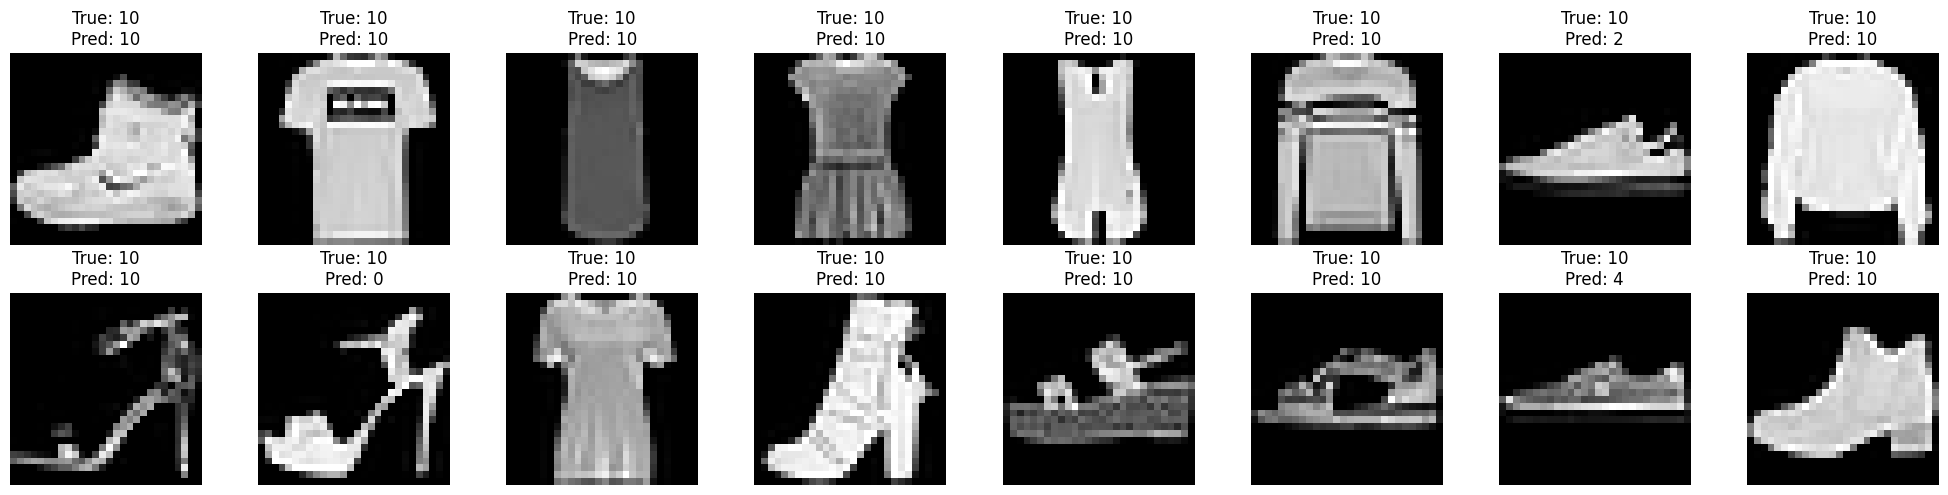

In [94]:
import matplotlib.pyplot as plt
import torch
import re
import os


latest_ckpt = find_latest_checkpoint("/content/drive/MyDrive/OOD_RnD/iterative_ckpt_dir")
model = ExtendedCNN(num_classes=11).to(device)
model.load_state_dict(torch.load(latest_ckpt)['model_state_dict'])
model.eval()

# --- Visualize predictions vs true labels ---
shown = 0
max_show = 16  # Total samples (must be even)
cols = max_show // 2
fig, axes = plt.subplots(2, cols, figsize=(2.5 * cols, 5))

with torch.no_grad():
    for images, labels in fmnist_loader:
        images = images.to(device)
        logits, _ = model(images)
        preds = torch.argmax(logits, dim=1)

        for i in range(max_show):
            ax = axes[i // cols][i % cols]
            ax.imshow(images[i][0].cpu().numpy(), cmap='gray')
            ax.set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
            ax.axis('off')
        break

plt.tight_layout()
plt.show()


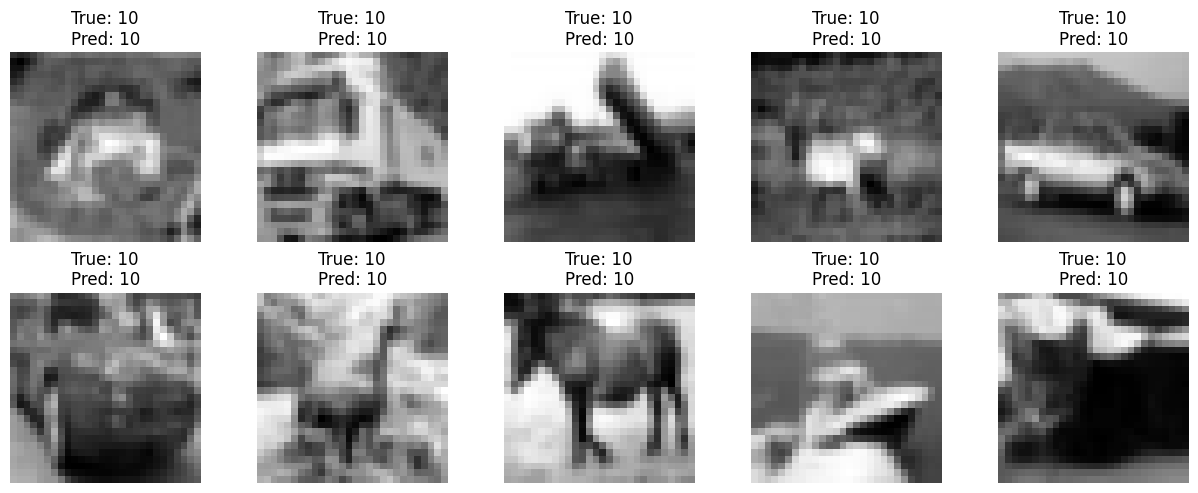

In [69]:
import matplotlib.pyplot as plt
import torch
import re
import os


latest_ckpt = find_latest_checkpoint("/content/drive/MyDrive/OOD_RnD/iterative_ckpt_dir")
model = ExtendedCNN(num_classes=11).to(device)
model.load_state_dict(torch.load(latest_ckpt)['model_state_dict'])
model.eval()

# --- Visualize predictions vs true labels ---
shown = 0
max_show = 10  # Total samples (must be even)
cols = max_show // 2
fig, axes = plt.subplots(2, cols, figsize=(2.5 * cols, 5))

with torch.no_grad():
    for images, labels in cifar10_loader:
        images = images.to(device)
        logits, _ = model(images)
        preds = torch.argmax(logits, dim=1)

        for i in range(max_show):
            ax = axes[i // cols][i % cols]
            ax.imshow(images[i][0].cpu().numpy(), cmap='gray')
            ax.set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
            ax.axis('off')
        break

plt.tight_layout()
plt.show()


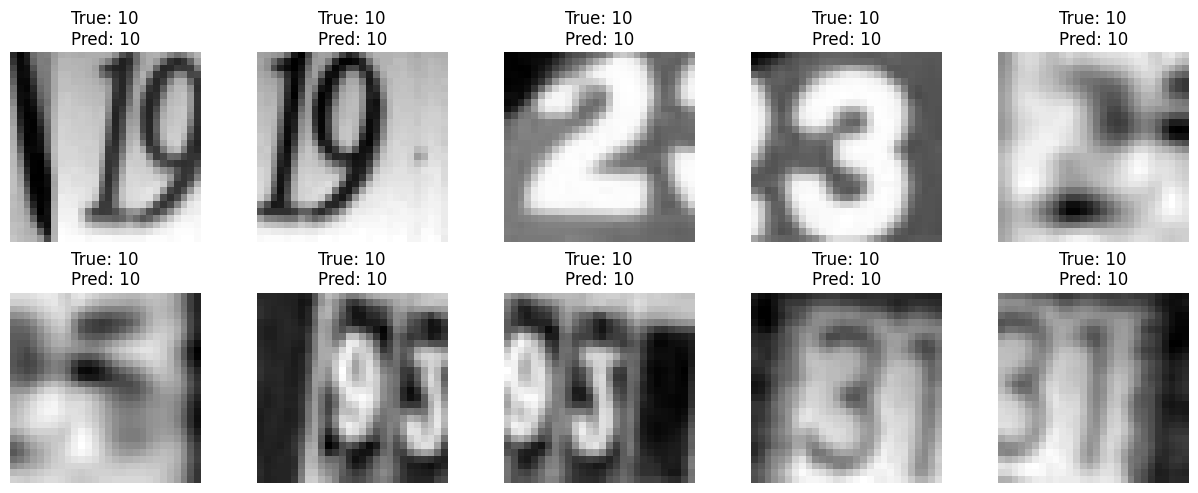

In [70]:
import matplotlib.pyplot as plt
import torch
import re
import os


latest_ckpt = find_latest_checkpoint("/content/drive/MyDrive/OOD_RnD/iterative_ckpt_dir")
model = ExtendedCNN(num_classes=11).to(device)
model.load_state_dict(torch.load(latest_ckpt)['model_state_dict'])
model.eval()

# --- Visualize predictions vs true labels ---
shown = 0
max_show = 10  # Total samples (must be even)
cols = max_show // 2
fig, axes = plt.subplots(2, cols, figsize=(2.5 * cols, 5))

with torch.no_grad():
    for images, labels in svhn_loader:
        images = images.to(device)
        logits, _ = model(images)
        preds = torch.argmax(logits, dim=1)

        for i in range(max_show):
            ax = axes[i // cols][i % cols]
            ax.imshow(images[i][0].cpu().numpy(), cmap='gray')
            ax.set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
            ax.axis('off')
        break

plt.tight_layout()
plt.show()


In [71]:
import os
import re

def find_latest_gen_file(gen_data_dir):
    files = os.listdir(gen_data_dir)
    gen_files = [f for f in files if f.startswith("gen_batch_step_") and f.endswith(".pt")]

    if not gen_files:
        raise FileNotFoundError("No generated sample files found.")

    steps = [int(re.search(r"gen_batch_step_(\d+)\.pt", f).group(1)) for f in gen_files]
    latest_step = max(steps)
    latest_file = f"gen_batch_step_{latest_step}.pt"
    return os.path.join(gen_data_dir, latest_file)


In [81]:
import os
import torch
import matplotlib.pyplot as plt

def find_epoch_files_sorted(gen_dir):
    return sorted([os.path.join(gen_dir, f) for f in os.listdir(gen_dir) if f.startswith('gen_epoch_') and f.endswith('.pt')],
                  key=lambda x: int(x.split('_')[-1].split('.')[0]))

def extract_epoch_number(filepath):
    return int(filepath.split('_')[-1].split('.')[0])



In [97]:
import os
import torch
import matplotlib.pyplot as plt

def plot_evolution_grid(gen_dir, num_classes=11, samples_per_cell=1, every_nth=5):

    # --- gather every-nth snapshot ---
    gen_files = sorted(
        [os.path.join(gen_dir, f) for f in os.listdir(gen_dir)
         if f.startswith('gen_epoch_') and f.endswith('.pt')],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )

    snapshots = []
    for path in gen_files:
        epoch = int(path.split('_')[-1].split('.')[0])
        if epoch == 1 or epoch % every_nth == 0:
            data = torch.load(path, map_location='cpu')
            snapshots.append((epoch, data['images'], data['labels']))
    snapshots.sort(key=lambda x: x[0])
    if not snapshots:
        raise ValueError("No matching snapshots found.")

    # --- create shared axes grid ---
    cols = len(snapshots)
    fig, axes = plt.subplots(
        num_classes, cols,
        figsize=(cols * 2, num_classes * 2),
        sharex=True, sharey=True
    )

    # ensure 2D axes array
    if num_classes == 1:
        axes = axes[None, :]
    if cols == 1:
        axes = axes[:, None]

    # --- plot each cell ---
    for col, (epoch, images, labels) in enumerate(snapshots):
        for row in range(num_classes):
            ax = axes[row, col]
            idxs = (labels == row).nonzero(as_tuple=True)[0].tolist()
            if not idxs:
                ax.axis('off')
                continue

            img = images[idxs[0]].squeeze().numpy()
            ax.imshow(img, cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

            if row == 0:
                ax.set_title(f"Epoch {epoch}", fontsize=10)

    # --- add a single y-axis label per row on the left margin ---
    for row in range(num_classes):
        # compute vertical center of that row in figure coordinates
        y = 1 - (row + 0.5) / num_classes
        fig.text(
            0.02, y,
            f"Class {row}",
            va='center', ha='left',
            rotation='vertical',
            fontsize=10
        )

    plt.tight_layout(rect=[0.02, 0, 1, 1])
    plt.show()


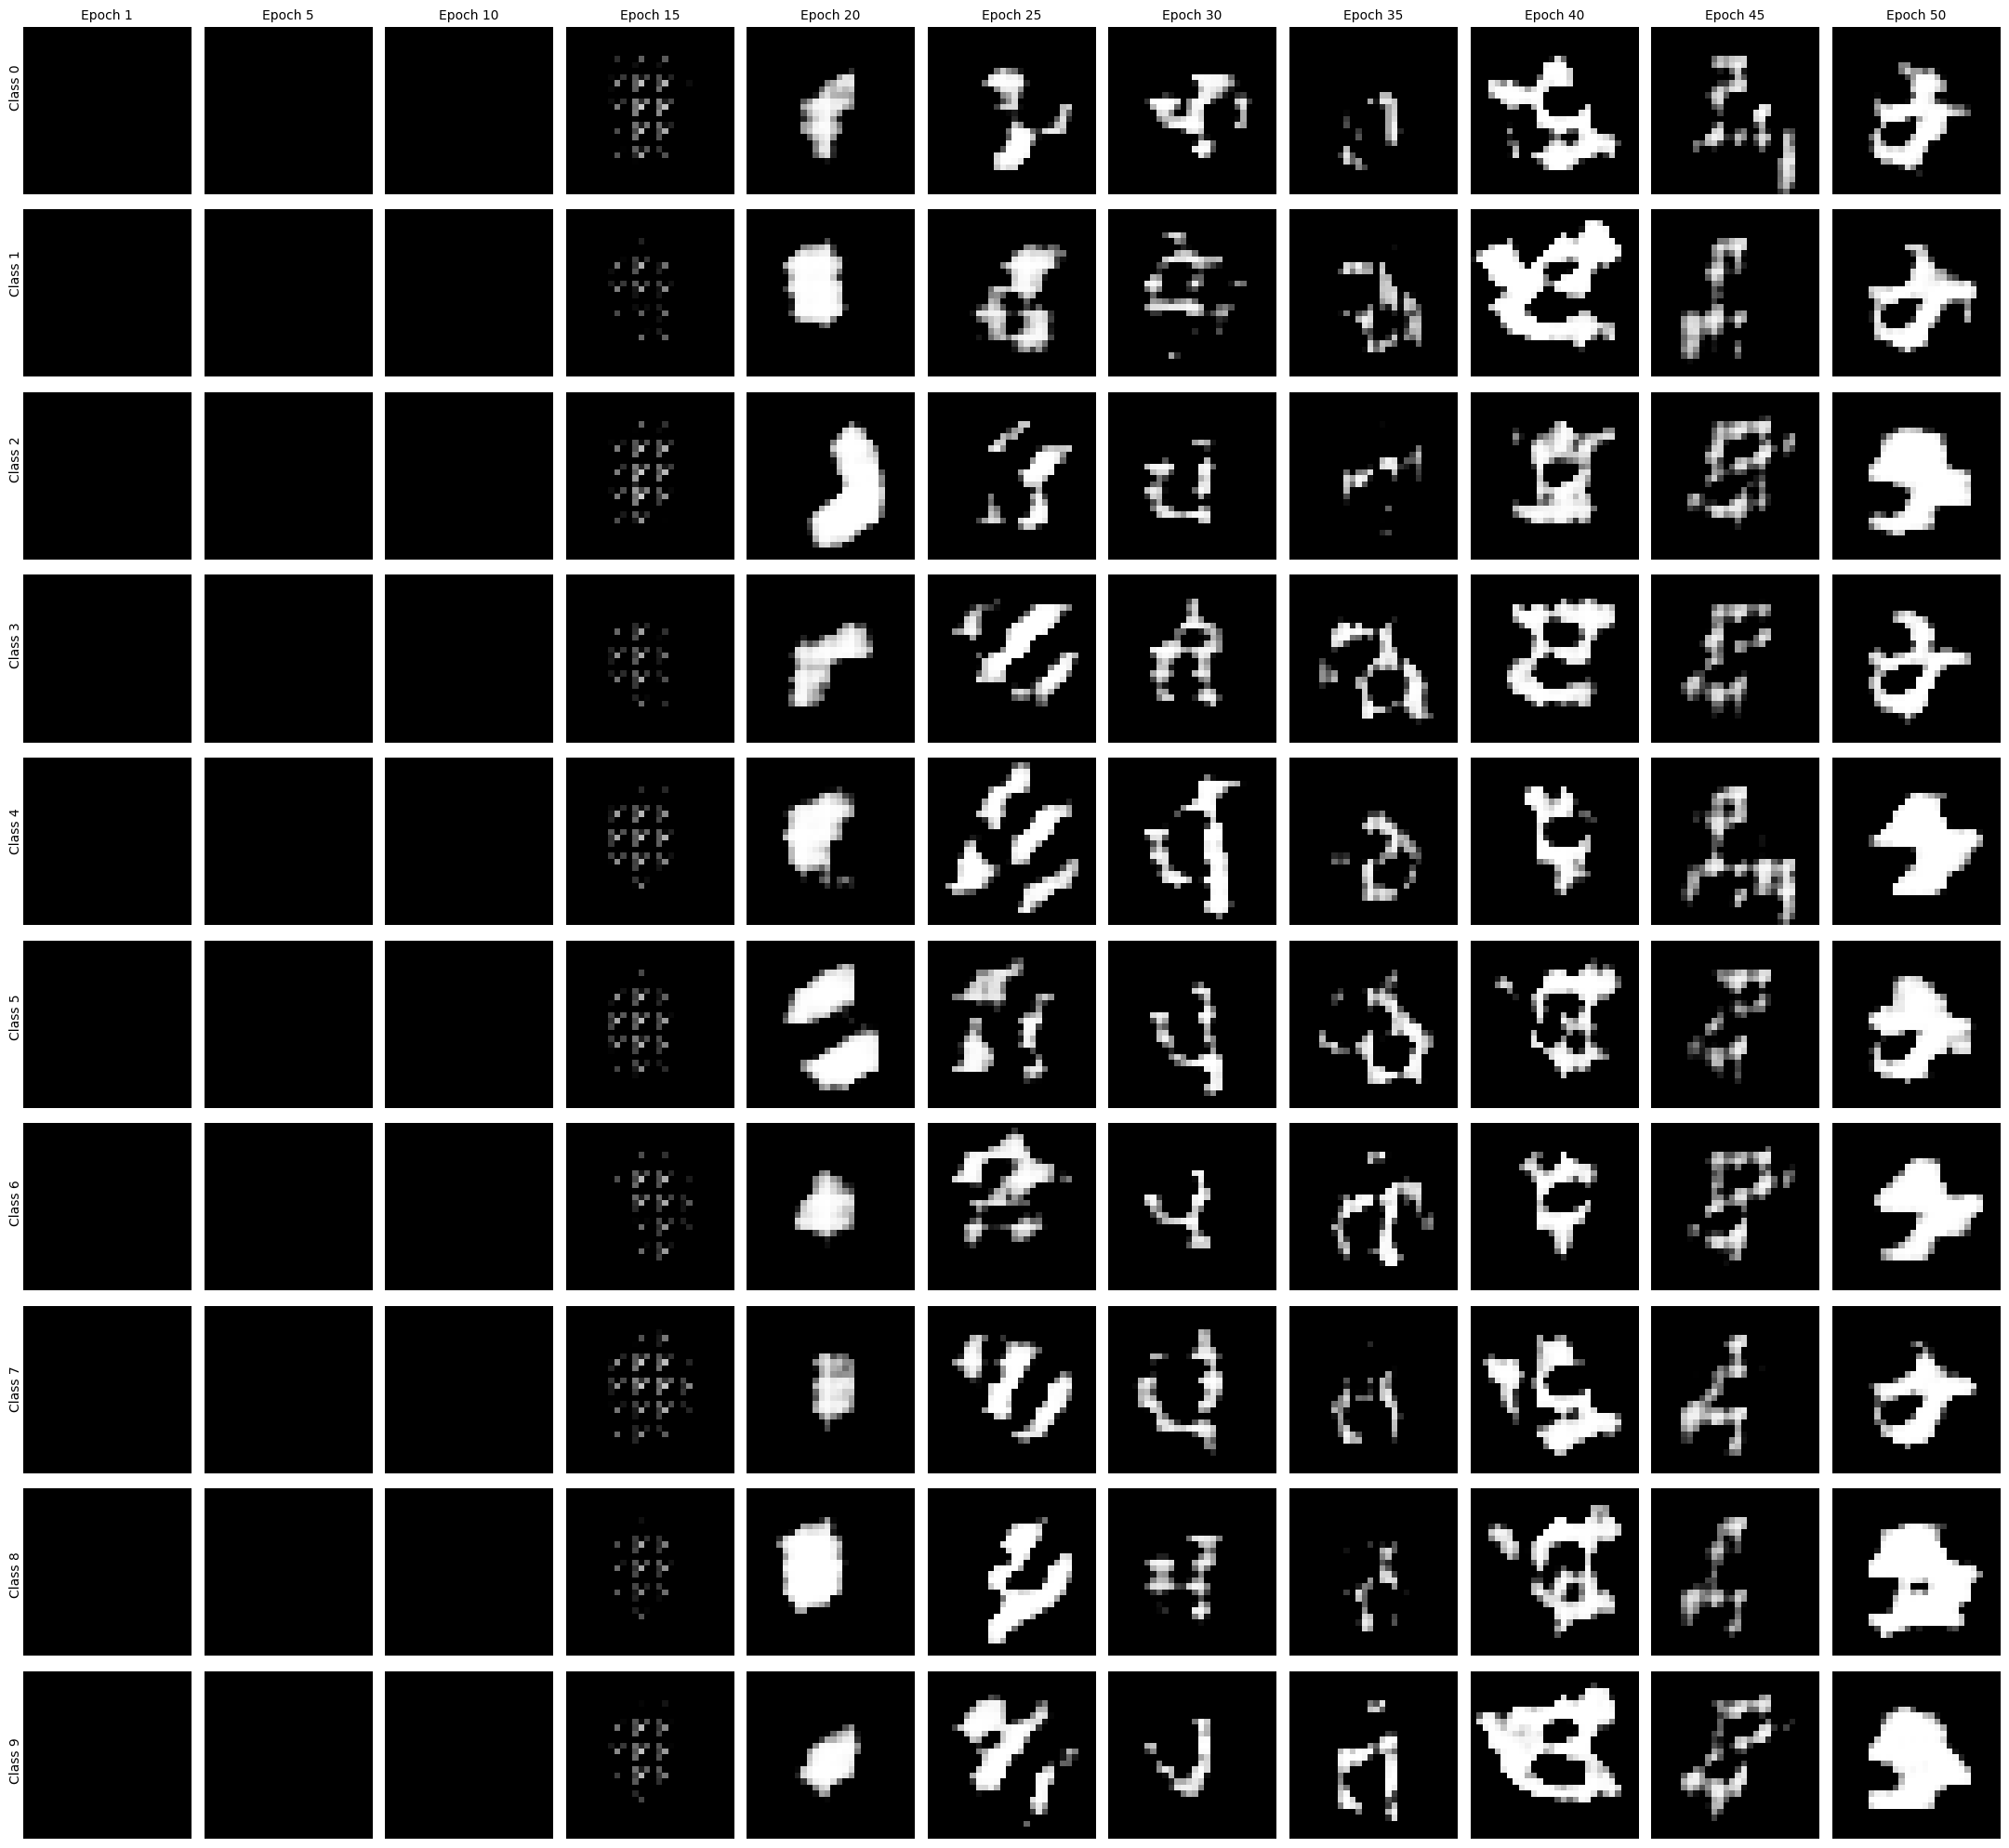

In [98]:
plot_evolution_grid(
    gen_dir= "/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    num_classes=10,
    samples_per_cell=1,
    every_nth= 5  # plot every 5 epochs
)

In [100]:
import math

def plot_class_evolution(gen_dir, target_class, samples_per_cell=1, every_nth=5, num_cols=5):
    gen_files = find_epoch_files_sorted(gen_dir)
    if not gen_files:
        raise ValueError(f"No gen_epoch_*.pt files in {gen_dir}")

    # Select subset of epochs
    snapshots = []
    for path in gen_files:
        epoch = extract_epoch_number(path)
        if epoch % every_nth == 0:
            data = torch.load(path, map_location='cpu')
            snapshots.append((epoch, data['images'], data['labels']))

    if not snapshots:
        raise ValueError("No matching snapshots found for selected epochs.")

    snapshots.sort(key=lambda x: x[0])

    num_epochs = len(snapshots)
    num_rows = math.ceil(num_epochs / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i, (epoch, images, labels) in enumerate(snapshots):
        ax = axes[i]
        idxs = (labels == target_class).nonzero(as_tuple=True)[0].tolist()

        if not idxs:
            ax.axis('off')
            continue

        idx = idxs[0] if len(idxs) == 1 else idxs[:samples_per_cell][0]
        img = images[idx].squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Epoch {epoch}", fontsize=8)
        ax.axis('off')

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Evolution of Class {target_class}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


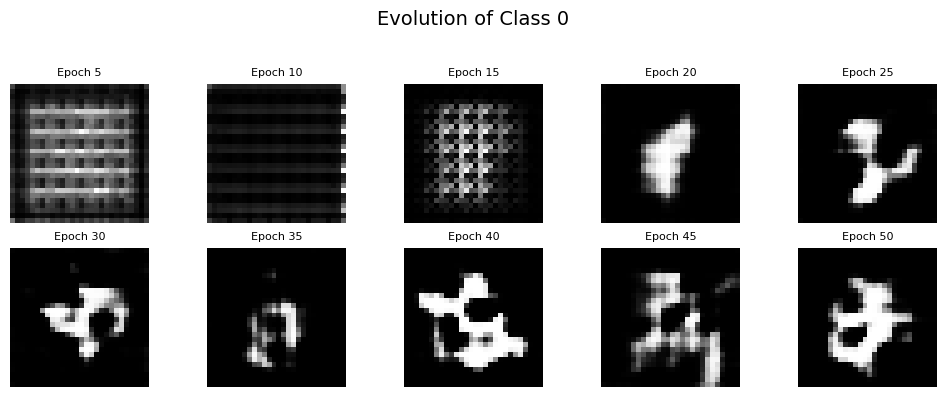

In [101]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=0,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

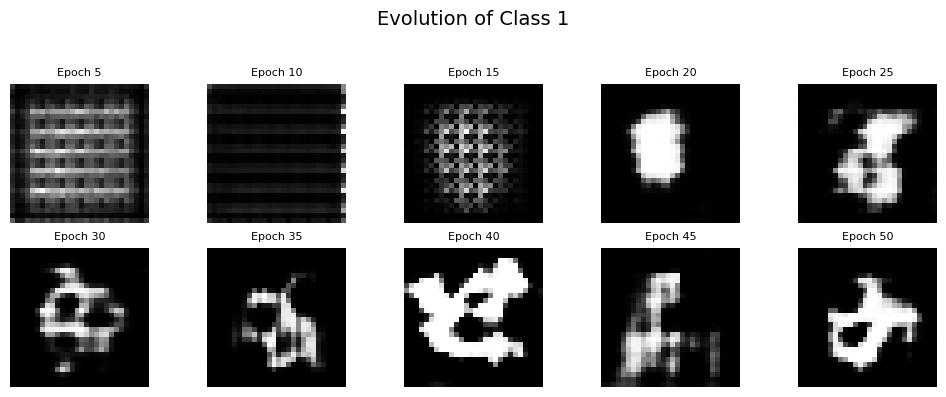

In [102]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=1,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

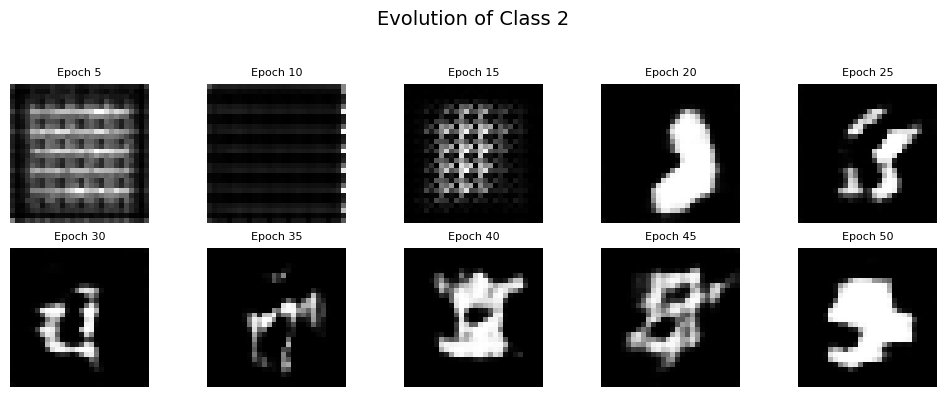

In [103]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=2,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

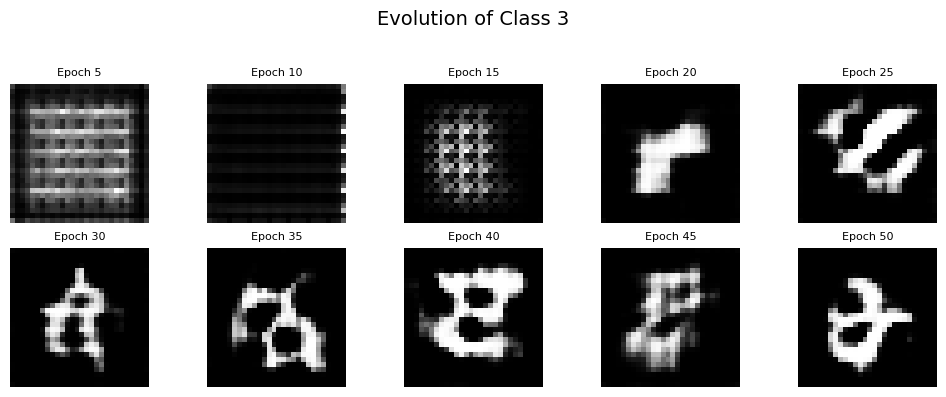

In [104]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=3,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

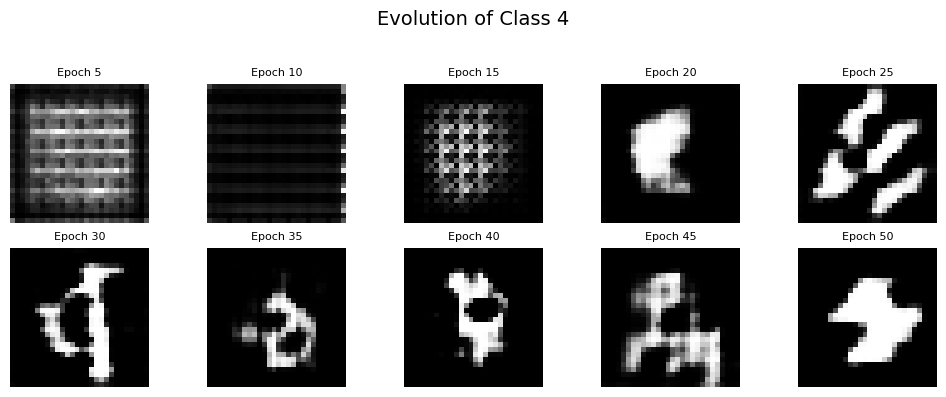

In [105]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=4,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

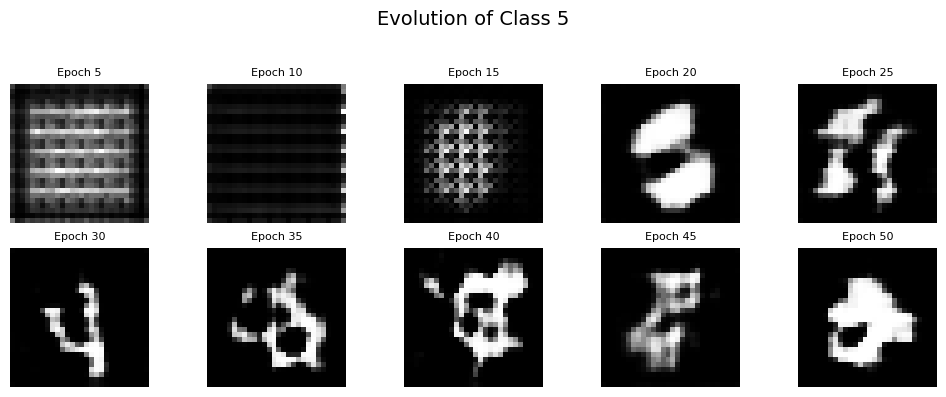

In [106]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=5,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

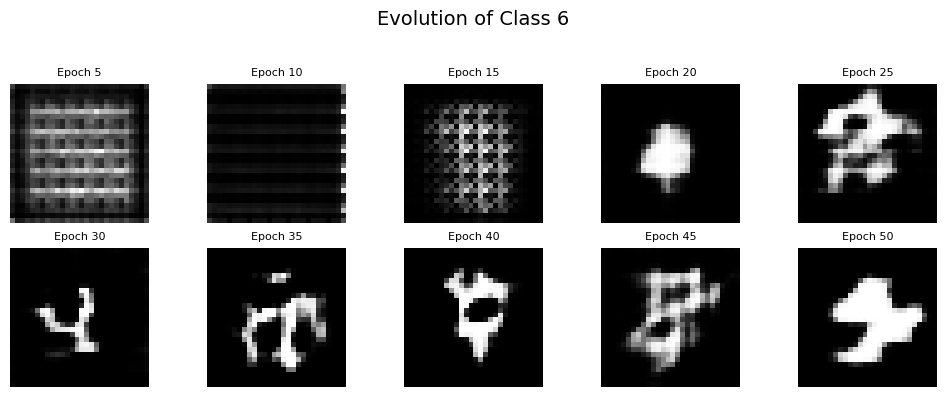

In [108]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=6,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

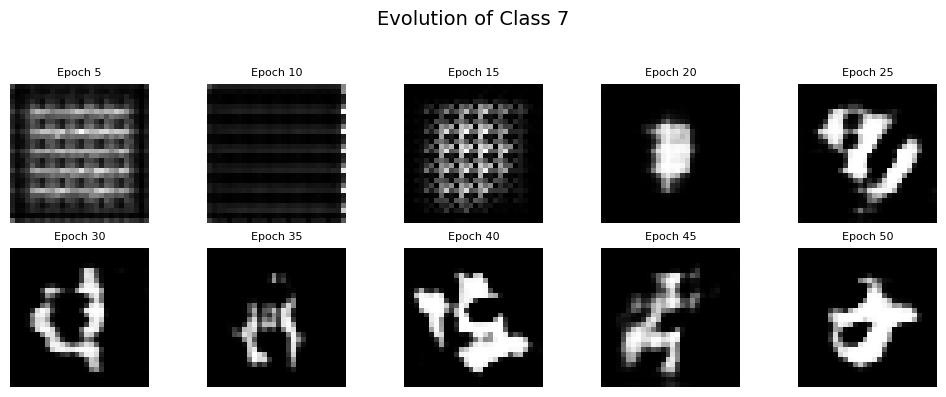

In [109]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=7,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

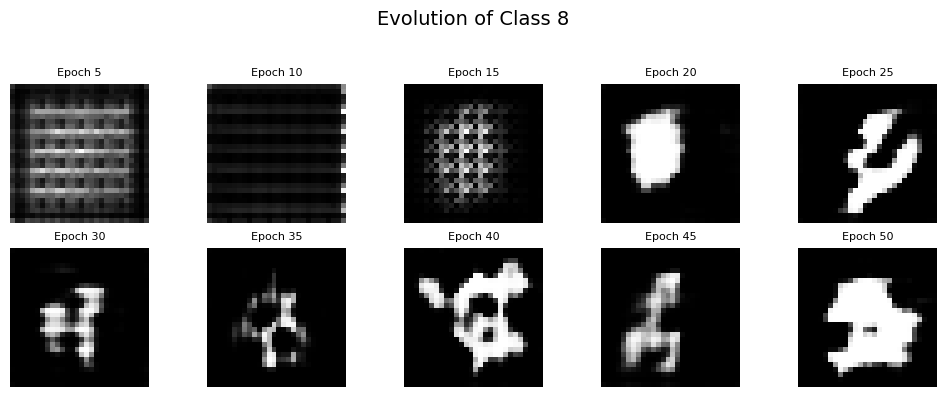

In [110]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=8,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)

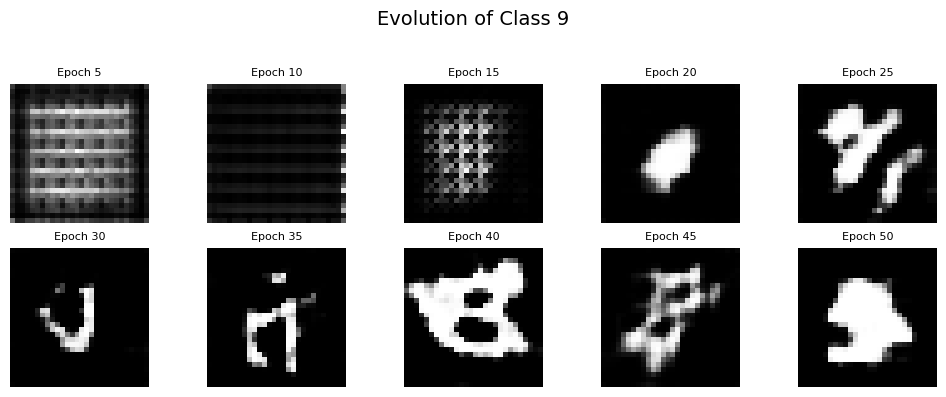

In [111]:
plot_class_evolution(
    gen_dir="/content/drive/MyDrive/OOD_RnD/gen_data_dir",
    target_class=9,
    samples_per_cell=1,
    every_nth=5,
    num_cols=5
)